# 14 Dimension Reduction of Matrix Data
# 14.1. Clustering 2D Data in 1-Dimension

Consider a scenario, in which we manage an online clothing store. When customers visit our website, they are asked to provide their height and weight. These 2D measurements are used to offer customers appropriately-sized clothing, based on whatever inventory is available. Our inventory comes in 3 sizes; Small, Medium, and Large. Given the measurement data for 180 customers, we would like to do the following:
 
 
1. We want to group our customers into 3 distinct clusters, based on size.

2. We want to build an interpretable model to determine the clothing-size category of each new customer, using our computed clusters.

3. We want our clustering to be simple enough for our non-technical investors to comprehend. 

The third point in particular limits our decisions. Our clustering can’t rely on technical concepts, such centroids or distances to the mean. Ideally, we’d be able to explain our model in a single figure. We can achieve this level of simplicity, using dimension reduction. However, we’ll first need to simulate the 2D measurement data for 180 customers.

**Listing 14. 1. Simulating a range of heights**

In [51]:
import numpy as np
heights = np.arange(60, 78, 0.1)

A linear relationship exists between height and weight. It has been shown that on average, a person's weight in pounds equals approximately `4 * height - 130`. Of course, each individual person's weight fluctuates around this average value. We'll model these random fluctuations using a Normal distribution with a standard deviation of 10 lb. Thus given a `height` variable, we can model the weight as `4 * height - 130 * np.random.normal(10)`. 

**Listing 14. 2. Simulating weights using heights**

In [52]:
np.random.seed(0)
random_fluctuations = np.random.normal(scale=10, size=heights.size)
weights = 4 * heights - 130 + random_fluctuations

We can treat the heights and weights as 2-dimensional coordinates within a `measurements` matrix. Lets store and plot these measured coordinates.

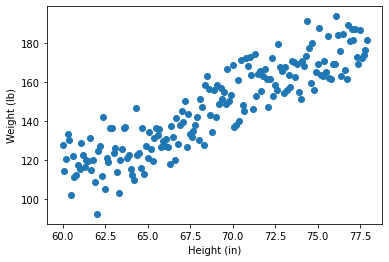

In [53]:
import matplotlib.pyplot as plt
measurements = np.array([heights, weights])
plt.scatter(measurements[0], measurements[1])
plt.xlabel('Height (in)')
plt.ylabel('Weight (lb)')
plt.show()

As expected, the height and weight axes are scaled differently. As a reminder, Matplotlib manipulates its 2D axes to make the final plot aesthetically pleasing. Normally, this is a good thing. However, we’ll soon be rotating the plot, in order to simplify our data. The rotation will shift the axes-scaling, making it difficult to compare. Consequently, we should equalize our axes to obtain a consistent visual output. 

**Plotting 2D measurements using equally-scaled axes**

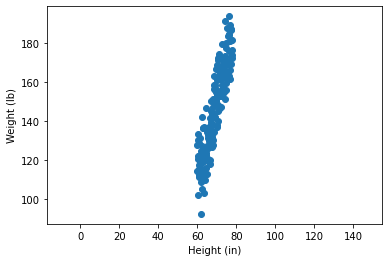

In [54]:
plt.scatter(measurements[0], measurements[1])
plt.xlabel('Height (in)')
plt.ylabel('Weight (lb)')
plt.axis('equal')
plt.show()

Our plot now forms a thin, cigar-like shape. If the cigar-shaped plot is positioned horizontally, then we could separate it into 3 parts, using 2 vertical slices.

We'll now attempt to cluster our 2D data by flipping the data on its side. This horizontal rotation will allow us to bloth cluster the data and also reduce it down to 1-dimension. 

### 14.1.1 Reducing Dimensions Using Rotation

In order to flip our data on its side, we must execute two separate steps:

1.	We must shift all of our data-points so that they are centered on the origin of the plot, which is located at coordinate (0, 0). This will make it easier to rotate the plot towards the x-axis.
2.	We must rotate the plotted data until the total distance of the data-points to the x-axis is minimized.

We'll start be shifting our data to the origin, by subtracting the mean height and the meean weight.

**Listing 14. 5. Centering the measurements at the origin**

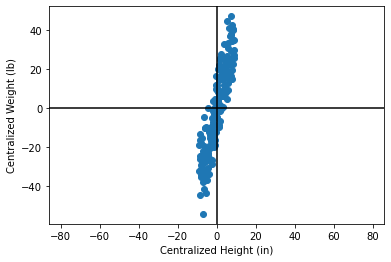

In [55]:
centered_data = np.array([heights - heights.mean(),
                          weights - weights.mean()])
plt.scatter(centered_data[0], centered_data[1])
plt.axhline(0, c='black')
plt.axvline(0, c='black')
plt.xlabel('Centralized Height (in)')
plt.ylabel('Centralized Weight (lb)')
plt.axis('equal')
plt.show()

Our data is now perfectly centered at the origin. We want to spin the plotted points around the origin, until they overlap with the x-axis. Rotating a 2D plot around its center requires the use of a **rotation matrix**. A rotation matrix is a 2-by-2 array of the form `np.array([[cos(x), -sin(x)], [sin(x), cos(x)]])`, where `x` is the angle of rotation. The matrix product of this array and `centered_data` will rotate the data by `x` radians. 

Lets utilize the rotation matrix to rotate `centered_data` clockwise by 90 degrees.

**Listing 14. 6. Rotating `centered_data` by 90 degrees**

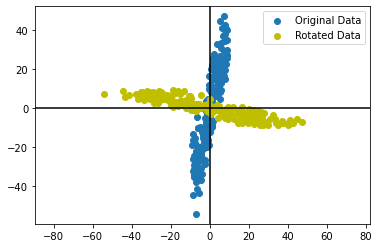

In [56]:
from math import sin, cos
angle = np.radians(-90)
rotation_matrix = np.array([[cos(angle), -sin(angle)], 
                            [sin(angle), cos(angle)]])

rotated_data = rotation_matrix @ centered_data
plt.scatter(centered_data[0], centered_data[1], label='Original Data')
plt.scatter(rotated_data[0], rotated_data[1], c='y', label='Rotated Data')
plt.axhline(0, c='black')
plt.axvline(0, c='black')
plt.legend()
plt.axis('equal')
plt.show()

our rotation has shifted the plot closer to the x-axis. We need a way to quantify this shift. Lets generate a penalty score that will decrease as the data is rotated towards the x-axis. 

We'll penalize all vertical y-axis values. Our penalty will be based on the concept of squared distance, which we introduced in Section Five. The penalty square will equal the average squared y-value of `rotated_data`. When a rotated dataset moves closer to the x-axis, its average squared y-value will decrease. 

**Listing 14. 7. Penalizing vertical y-values**

In [57]:
data_labels = ['unrotated', 'rotated']
data_list = [centered_data, rotated_data]
for data_label, data in zip(data_labels, data_list):
    y_values = data[1]
    penalty = y_values @ y_values / y_values.size
    print(f"The penalty score for the {data_label} data is {penalty:.2f}")

The penalty score for the unrotated data is 519.82
The penalty score for the rotated data is 27.00


Rotating the data has reduced the penalty score by more than 20-fold. Furthermore, we can mathematically show that penalty score is equal to the y-axis variance (`y_values.var()`). Consequently, our data rotation has reduced the y-axis variance by more than 20-fold. We'll confirm below.

**Listing 14. 8. Equating penalties with y-axis variance**

In [58]:
for data_label, data in zip(data_labels, data_list):
    y_var = data[1].var()
    penalty = data[1] @ data[1] / data[0].size
    assert round(y_var, 14) == round(penalty, 14)
    print(f"The y-axis variance for the {data_label} data is {y_var:.2f}")

The y-axis variance for the unrotated data is 519.82
The y-axis variance for the rotated data is 27.00


We can score rotations based on variance. Rotating the data towards the x-axis reduces the variance along the y-axis. How does this rotation influence the variance along the x-axis? Lets find out.

**Listing 14. 9. Measuring rotational x-axis variance**

In [59]:
for data_label, data in zip(data_labels, data_list):
    x_var = data[0].var()
    print(f"The x-axis variance for the {data_label} data is {x_var:.2f}")

The x-axis variance for the unrotated data is 27.00
The x-axis variance for the rotated data is 519.82


The rotation has completely flipped the x-axis variance and the y-axis variance. However, the total sum of variance-values has remaine unchanged. Total variance is conserved, even after the rotation. We'll verify this fact below.

**Listing 14. 10. Confirming the conservation of total variance**

In [60]:
total_variance = centered_data[0].var() + centered_data[1].var()
assert total_variance == rotated_data[0].var() + rotated_data[1].var()

Conservation of variance allows us to infer the following:

* x-axis variance and y-axis variance can be combined into a single percentage-score, where `x_values.var() / total_variance` is equal to `1 - y_values.var() / total_variance`. 
* Rotating the data towards the x-axis will lead to an increase in the x-axis variance, and to an equivalent decrease in y-axis variance.

The following code confirms all these conclusions.

**Listing 14. 11. Exploring the percent coverage of axis-variance**

In [61]:
for data_label, data in zip(data_labels, data_list):
    percent_x_axis_var = 100 * data[0].var() / total_variance
    percent_y_axis_var = 100 * data[1].var() / total_variance
    print(f"In the {data_label} data, {percent_x_axis_var:.2f}% of the "
           "total variance is distributed across the x-axis")
    print(f"The remaining {percent_y_axis_var:.2f}% of the total "
           "variance is distributed across the y-axis\n")

In the unrotated data, 4.94% of the total variance is distributed across the x-axis
The remaining 95.06% of the total variance is distributed across the y-axis

In the rotated data, 95.06% of the total variance is distributed across the x-axis
The remaining 4.94% of the total variance is distributed across the y-axis



Lets rotate `centered_data` even further, until its distance to the x-axis is minimized. Minimizing the distance to the x-axis is equivalent to maximizing the percent of total variance covered by the x-axis.

**Listing 14. 12. Maximizing horizontal dispersion**

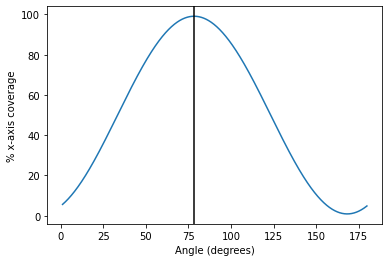

The horizontal variance is maximized to approximately 541 after a 78.3 degree rotation.
That rotation distributes 99.08% of the total variance onto the x-axis.


In [62]:
def rotate(angle, data=centered_data):
    angle = np.radians(-angle)
    rotation_matrix = np.array([[cos(angle), -sin(angle)], 
                                [sin(angle), cos(angle)]])
    return rotation_matrix @ data

angles = np.arange(1, 180, 0.1)
x_variances = [(rotate(angle)[0].var()) for angle in angles]

percent_x_variances = 100 * np.array(x_variances) / total_variance 
optimal_index = np.argmax(percent_x_variances)
optimal_angle = angles[optimal_index]
plt.plot(angles, percent_x_variances)
plt.axvline(optimal_angle, c='k')
plt.xlabel('Angle (degrees)')
plt.ylabel('% x-axis coverage')
plt.show()

max_coverage = percent_x_variances[optimal_index]
max_x_var = x_variances[optimal_index]

print("The horizontal variance is maximized to approximately "
      f"{int(max_x_var)} after a {optimal_angle:.1f} degree rotation.")
print(f"That rotation distributes {max_coverage:.2f}% of the total "
       "variance onto the x-axis.")

Rotating `centered_data` by 78.3 degrees will maximize the horizontal dispersion. At that rotation angle, 99.08% of the total variance will be distributed across the x-axis. Thus, we can expect the rotated data to mostly lie along the 1D axis line. 

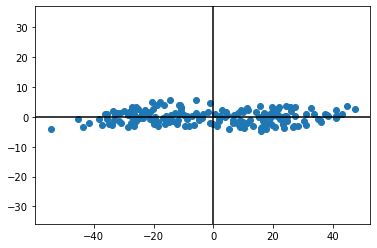

In [63]:
best_rotated_data = rotate(optimal_angle)
plt.scatter(best_rotated_data[0], best_rotated_data[1])
plt.axhline(0, c='black')
plt.axvline(0, c='black')
plt.axis('equal')
plt.show()

Most of the data lies close to the x-axis. Consequently, we can delete all y-axis coordinates with minimal information loss.  Lets reduce `best_rotated_data` to 1D by disposing of the y-axis. Afterwards, we'll leverage the remaining 1D array to extract 2 clustering thresholds. The first threshold will separate the small-sized customers from the medium-sized customers. The second threshold will separate the medium-sized customers from the large-sized customers. 

**Listing 14. 14. Reducing the rotated data to 1D for the purposes of clustering**

In [64]:
x_values = best_rotated_data[0]
sorted_x_values = sorted(x_values)
cluster_size = int(x_values.size / 3)
small_cutoff = max(sorted_x_values[:cluster_size])
large_cutoff = min(sorted_x_values[-cluster_size:])
print(f"A 1D threshold of {small_cutoff:.2f} separates the small-sized "
       "and medium-sized customers.")
print(f"A 1D threshold of {large_cutoff:.2f} separates the medium-sized "
      "and large-sized customers.")

A 1D threshold of -14.61 separates the small-sized and medium-sized customers.
A 1D threshold of 15.80 separates the medium-sized and large-sized customers.


We can visualize our thresholds by utilizing them to vertically slice our `best_reduced_data` plot. The 2 slices will split the plot into 3 segments. Each segment will correspond to a customer size.

**Listing 14. 15. Plotting horizontal customer data separated out into the segments**

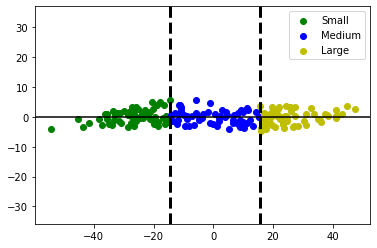

In [65]:
def plot_customer_segments(horizontal_2d_data):
    small, medium, large = [], [], []
    cluster_labels = ['Small', 'Medium', 'Large']
    for x_value, y_value in horizontal_2d_data.T: 
        if x_value <= small_cutoff:
            small.append([x_value, y_value])
        elif small_cutoff < x_value < large_cutoff:
            medium.append([x_value, y_value])
        else:
            large.append([x_value, y_value])
    
    for i, cluster in enumerate([small, medium, large]):
        cluster_x_values, cluster_y_values = np.array(cluster).T
        plt.scatter(cluster_x_values, cluster_y_values,
                    color=['g', 'b', 'y'][i],
                    label=cluster_labels[i])
    
    plt.axhline(0, c='black')
    plt.axvline(large_cutoff, c='black', linewidth=3, linestyle='--')
    plt.axvline(small_cutoff, c='black', linewidth=3, linestyle='--')
    plt.axis('equal')
    plt.legend()
    plt.show()

plot_customer_segments(best_rotated_data)

Our 1D `x_values` array can sufficiently segment the customer data, because it captures 99.08% of the data’s variance. Consequently, we can leverage the array to reproduce 99.08% of our `centered_data` dataset. We simply need to reintroduce the y-axis dimension. Afterwards, we'll need to rotate the resulting array back to its original position.

**Listing 14. 16. Reproducing 2D data from a 1D array**

In [66]:
zero_y_values = np.zeros(x_values.size)
reproduced_data = rotate(-optimal_angle, data=[x_values, zero_y_values])

Lets plot `reproduced_data` together with the our `centered_data` matrix in order to gage the quality of the reproduction.

**Listing 14. 17. Plotting reproduced and original data**

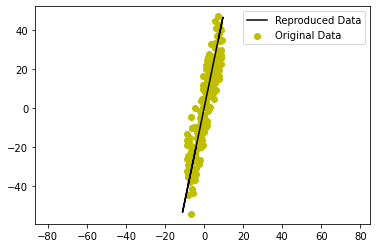

In [67]:
plt.plot(reproduced_data[0], reproduced_data[1], c='k', 
         label='Reproduced Data')
plt.scatter(centered_data[0], centered_data[1], c='y', 
            label='Original Data')
plt.axis('equal')
plt.legend()
plt.show()

The reproduced data forms a line, which cuts directly through the middle of the `centered_data` scatter-plot. The line represents the **first principal direction** of our data. We can leverage the first principal direction to process the heights and weights of future customers. We'll assume that these customers originate from the same distribution that underlies our existing `measurements` data. If so, then their centralized heights and weights will also lie along the first principal direction. Lets explore this scenario more concretely by simulating new customer measurements. 

**Listing 14. 18. Simulating and plotting new customer data**

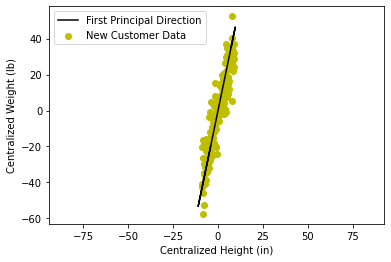

In [68]:
np.random.seed(1)
new_heights = np.arange(60, 78, .11) 
random_fluctuations = np.random.normal(scale=10, size=new_heights.size)
new_weights =  4 * new_heights - 130 + random_fluctuations
new_centered_data = np.array([new_heights - heights.mean(),
                              new_weights - weights.mean()])
plt.scatter(new_centered_data[0], new_centered_data[1], c='y', 
            label='New Customer Data')
plt.plot(reproduced_data[0], reproduced_data[1], c='k', 
         label='First Principal Direction')
plt.xlabel('Centralized Height (in)')
plt.ylabel('Centralized Weight (lb)')
plt.axis('equal')
plt.legend()
plt.show()

Our new customer data continues to lie along the first principal direction. Consequently, we can flip our new data on its side by rotating it 78.3 degrees. The resulting horizontal x-values will cover more than 99% of the total variance. The high horizontal dispersion will permit us to segment our customers by size without relying on y-value information. 

**Listing 14. 19. Rotating and segmenting our new customer data**

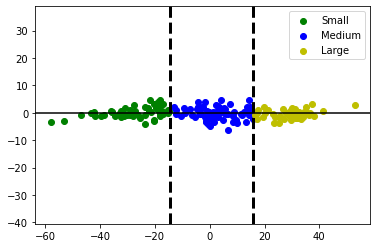

In [69]:
new_horizontal_data = rotate(optimal_angle, data=new_centered_data)
plot_customer_segments(new_horizontal_data)

Thus far, we have extracted the first principal direction by rotating our data so as to maximize the variance. Unfortunately, this technique will not scale to higher dimensions. Fortunately, there's an easier way to extract all principal directions. We just need to apply scalable algorithm known as **Principal Component Analysis**. That algorithm’s name is commonly shortened to **PCA**.

## 14.2. Dimension Reduction Using PCA and Scikit-Learn

Scikit-Learn provides a Principal Component Analysis class called `PCA`. Lets import `PCA` from `sklearn.decomposition`.

**Listing 14. 20. Importing PCA from Scikit-Learn**

In [70]:
from sklearn.decomposition import PCA

Next, we'll initialize `PCA`.

**Listing 14. 21. Initializing a `pca_model` object**

In [71]:
pca_object = PCA()

We’ll now apply `PCA` to our `measurements` array in order to horizontally orient that data. Afterwards, we'll plot the columns of the resulting `pca_transformed_data` matrix. The plot of the two columns should resemble a cigar that’s lying on its side

**Listing 14. 22. Running PCA using Scikit-Learn**

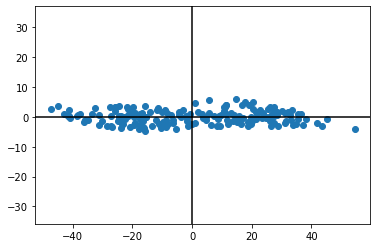

In [72]:
pca_transformed_data = pca_object.fit_transform(measurements.T)
plt.scatter(pca_transformed_data[:,0], pca_transformed_data[:,1])
plt.axhline(0, c='black')
plt.axvline(0, c='black')
plt.axis('equal')
plt.show()

Even though our plotted data is oriented differently, its x-axis variance coverage should still remain consistent with our previous ovservations. We can confirm using the `explained_variance_ratio_` attribute of `pca_object`.

**Listing 14. 23. Extracting variance from Scikit-Learn’s PCA output**

In [73]:
percent_variance_coverages = 100 * pca_object.explained_variance_ratio_ 
x_axis_coverage, y_axis_coverage = percent_variance_coverages
print(f"The x-axis of our PCA output covers {x_axis_coverage:.2f}% of "
       "the total variance")

The x-axis of our PCA output covers 99.08% of the total variance


Our `pca_object` has maximized the x-axis variance of the input data. It has done so by uncovering the dataset’s 2 principal directions. These directions are stored as vectors within the `pca.components` attribute (which is itself a matrix). The first principal direction is represented as a vector, which is called  the **first principal component**. 

**Listing 14. 24. Outputting the first principal component**

In [74]:
from numpy.linalg import norm
first_pc = pca_object.components_[0]
magnitude = norm(first_pc)
print(f"Vector {first_pc} points in a direction that covers "
      f"{x_axis_coverage:.2f}% of the total variance.")
print(f"The vector has a magnitude of {magnitude}")

Vector [-0.20223994 -0.979336  ] points in a direction that covers 99.08% of the total variance.
The vector has a magnitude of 1.0


The first principal component is a unit-vector, with a magnitude of 1.0. It stretches one whole unit-length from the origin. If we stretch it far enough, we can capture the entire principal direction of our data.

**Listing 14. 25. Stretching a unit-vector to cover the first principal direction**

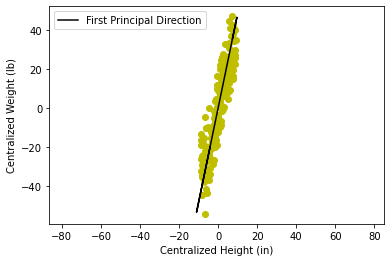

In [75]:
def plot_stretched_vector(v, **kwargs): 
    plt.plot([-50 * v[0], 50 * v[0]], [-50 * v[1], 50 * v[1]], **kwargs)
    
plt.plot(reproduced_data[0], reproduced_data[1], c='k', 
         label='First Principal Direction')
plt.scatter(centered_data[0], centered_data[1], c='y')
plt.xlabel('Centralized Height (in)')
plt.ylabel('Centralized Weight (lb)')
plt.axis('equal')
plt.legend()
plt.show()

The second principal direction is perpendicular to the first. Its vectorized representation is called the **second principal component**. Both the first and second principal components share a special relationship with the x and y axes of our data. Visually uncovering that relationship will make dimension reduction conceptually easier to comprehend. Hence, we’ll now proceed to stretch and plot both the components within the `components` matrix. Additionally, we’ll plot `centered_data`, as well as both our axes.

**Listing 14. 26. Plotting all principal directions, along with axes and data-information**

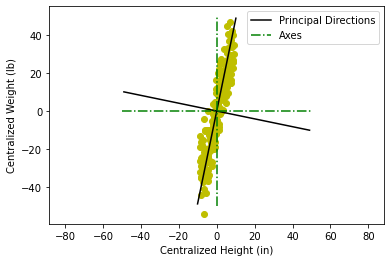

In [76]:
principal_components = pca_object.components_
for i, pc in enumerate(principal_components):
    plot_stretched_vector(pc, c='k', 
                          label='Principal Directions' if i == 0 else None)
    
for i, axis_vector in enumerate([np.array([0, 1]), np.array([1, 0])]):
    plot_stretched_vector(axis_vector,  c='g', linestyle='-.', 
                          label='Axes' if i == 0 else None)

plt.scatter(centered_data[0], centered_data[1], c='y')
plt.xlabel('Centralized Height (in)')
plt.ylabel('Centralized Weight (lb)')
plt.axis('equal')
plt.legend()
plt.show()

The first and second principal directions are essentially a rotated version of the x and y axes. In other words, rotating the data is equivalent to swapping the axes with the principal directions. Swapping our 2 axes for the principal directions is referred to as a **projection onto the principal directions**. Using trigonometry, one can show that the projection of `centered_data` onto the principal directions is equal to the matrix product of `centered_data` and the 2 principal components.

**Listing 14. 27. Swapping standard axes for principal directions, using projection**

In [77]:
projections = principal_components @ centered_data
assert np.allclose(pca_transformed_data.T, projections)

Suppose we project a 4D dataset onto its four principal directions. The dataset’s standard axes will thus be swapped with its principal directions. Under the right circumstances, two of the new axes will cover a good chunk of the variance. Consequently, the remaining axes couldy be discarded, with minimized information loss.

## 14.3. Clustering 4D Data in 2-Dimensions

Imagine we are botanists, studying flowers in a blooming meadow. We randomly select 150 flowers. For every flower, we record 4 measurements. These 4D flower measurements already exist. We can access them using Scikit-Learn.

**Listing 14. 28. Loading flower measurements from Scikit-Learn**

In [78]:
from sklearn.datasets import load_iris
flower_data = load_iris()
flower_measurements = flower_data['data']
num_flowers, num_measurements = flower_measurements.shape
print(f"{num_flowers} flowers have been measured.")
print(f"{num_measurements} measurements were recorded for every flower.")
print("The first flower has the following measurements (in cm): " 
      f"{flower_measurements[0]}")

150 flowers have been measured.
4 measurements were recorded for every flower.
The first flower has the following measurements (in cm): [5.1 3.5 1.4 0.2]


Our data is 4-dimensional, but we want to plot it in 2D. Reducing the flower data to two dimensions requires that we project the dataset onto its first and second principal directions.

**Listing 14. 29. Reducing flower measurements to two dimensions**

In [79]:
pca_object_2D = PCA(n_components=2)
transformed_data_2D = pca_object_2D.fit_transform(flower_measurements)

The computed `transformed_data_2D` matrix should be 2-dimensional. Therefore, it should contain just two columns.

**Listing 14. 30. Checking the shape of a dimensionally reduced matrix**

In [80]:
row_count, column_count = transformed_data_2D.shape
print(f"The matrix contains {row_count} rows, corresponding to "
      f"{row_count} recorded flowers.")
print(f"It also contains {column_count} columns, corresponding to "
      f"{column_count} dimensions.") 

The matrix contains 150 rows, corresponding to 150 recorded flowers.
It also contains 2 columns, corresponding to 2 dimensions.


How much of the total data-variance is covered by our outputted data matrix? We can find out, using the `explained_variance_ratio_` attribute of `pca_object_2D`.

**Listing 14. 31. Measuring the variance-coverage of a dimensionally reduced matrix**

In [81]:
def print_2D_variance_coverage(pca_object): 
    percent_var_coverages = 100 * pca_object.explained_variance_ratio_
    x_axis_coverage, y_axis_coverage = percent_var_coverages
    total_coverage = x_axis_coverage + y_axis_coverage
    print(f"The x-axis covers {x_axis_coverage:.2f}% "
    	    "of the total variance")
    print(f"The y-axis covers {y_axis_coverage:.2f}% "
           "of the total variance")
    print(f"Together, the 2 axes cover {total_coverage:.2f}% "
           "of the total variance")
    
print_2D_variance_coverage(pca_object_2D)

The x-axis covers 92.46% of the total variance
The y-axis covers 5.31% of the total variance
Together, the 2 axes cover 97.77% of the total variance


Our dimensionally-reduced matrix covers more than 97% of the total data variance. Thus, a scatter plot of `transformed_data_2D` should display most of the clustering patterns present in the dataset.

**Listing 14. 32. Plotting flower data in 2D**

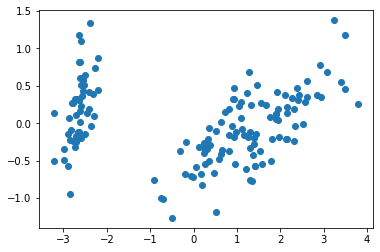

In [82]:
plt.scatter(transformed_data_2D[:,0], transformed_data_2D[:,1])
plt.show()

Based on the plot clustering, we can assume that 2 or 3 flower-types are present. In fact, our measured data represents 3 unique species of flower. This species information is stored within the `flower_data` dictionary. Lets color each plotted flower by species

**Listing 14. 33. Coloring plotted data by flower species**

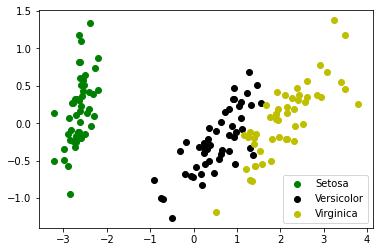

In [83]:
def visualize_flower_data(dim_reduced_data):
    species_names = flower_data['target_names']
    for i, species in enumerate(species_names):
        species_data = np.array([dim_reduced_data[j] 
                                 for j in range(dim_reduced_data.shape[0])
                                 if flower_data['target'][j] == i]).T
        plt.scatter(species_data[0], species_data[1], label=species.title(),
                     color=['g', 'k', 'y'][i])
    plt.legend()
    plt.show()

visualize_flower_data(transformed_data_2D)

_Versicolor_ and _Virgincia_ share a bit of overlap, implying that they have similar petal properties. On the other hand, _Setosa_ forms an entirely separate cluster. A vertical x-value threshold of -2 is sufficient to isolate _Setosa_ from the other 2 species of flowers.

**Listing 14. 34. Defining a Setosa detector based on dimensionally-reduced data**

In [84]:
def detect_setosa(flower_sample):
    centered_sample = flower_sample - pca_object_2D.mean_
    projection = pca_object_2D.components_[0] @ centered_sample
    if projection < -2:
        print("The sample could be a Setosa")
    else:
        print("The sample is not a Setosa")

new_flower_sample = np.array([4.8, 3.7, 1.2, 0.24])
detect_setosa(new_flower_sample)

The sample could be a Setosa


### 14.3.1. Limitations of PCA

PCA is overly sensitive to units of measurement. For example, our flower measurements are all in centimeters. However, one can imagine converting the first axis into millimeters. The information content of that axis should not change. However, its variance will shift. 

**Listing 14. 35. Measuring the effect of unit-change on axis variance**

In [85]:
first_axis_var = flower_measurements[:,0].var()
print(f"The variance of the first axis is: {first_axis_var:.2f}")

flower_measurements[:,0] *= 10
first_axis_var = flower_measurements[:,0].var()
print("We've converted the measurements from cm to mm.\nThat variance "
      f"now equals {first_axis_var:.2f}")

The variance of the first axis is: 0.68
We've converted the measurements from cm to mm.
That variance now equals 68.11


Now, the first-axis variance dominates our dataset. Consider the consequences of running PCA on these modified flower measurements. Consequently, PCA will project all the data onto the first-axis. Our reduced data will collapse to 1-dimension.

**Listing 14. 36. Measuring the effect of unit-change on PCA**

In [86]:
pca_object_2D.fit_transform(flower_measurements)
print_2D_variance_coverage(pca_object_2D) 

The x-axis covers 98.49% of the total variance
The y-axis covers 1.32% of the total variance
Together, the 2 axes cover 99.82% of the total variance


If we normalize our axes, than all the axes-values will lie between 0 and 1. The dominance of the first-axes will thusly be eliminated. 

**Listing 14. 37. Normalizing data to eliminate measurement-unit differences**

In [87]:
for i in range(flower_measurements.shape[1]):
    flower_measurements[:,i] /= norm(flower_measurements[:,i])
    
transformed_data_2D = pca_object_2D.fit_transform(flower_measurements)
print_2D_variance_coverage(pca_object_2D)

The x-axis covers 94.00% of the total variance
The y-axis covers 3.67% of the total variance
Together, the 2 axes cover 97.67% of the total variance


Normalization has slightly modified our data. Despite these changes, the total 2D variance coverage still sums to approximately 97%. We'll replot the PCA output in order to confirm that the 2D clustering patterns remain unchanged,

**Listing 14. 38. Plotting 2D PCA output after normalization**

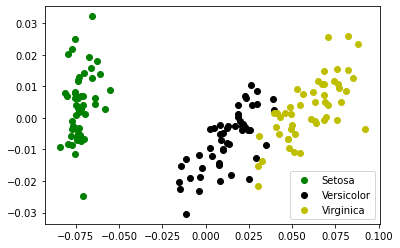

In [88]:
visualize_flower_data(transformed_data_2D)

Unfortunately, normalization does carry certain unintended consequences. All values now lie less than 1-unit from their mean. This is a problem. PCA requires us to subtract the mean from each axis-value, in order to centralize our data. However, it's computationally difficult to subtract the mean from a value that is very close to that mean. This substraction could cause errors.

**Listing 14. 39. Illustrating errors caused by values proximate to their mean**

In [89]:
data = np.array([1 + 1e-3, 1 - 1e-3])
mean = data.mean()
assert mean == 1
centralized_data = data - 2 * [mean]
assert centralized_data.mean() != 0
print(f"Actual mean is equal to {centralized_data.mean()}")

Actual mean is equal to -5.551115123125783e-17


We cannot reliably centralize data that lies close to the mean. Hence, we can't reliably execute PCA on normalized data. What should we do?

A solution to our problem does exist. However, to derive it, we must dive deep into the guts of the PCA algorithm. We must learn how to compute the principal components from scratch, without rotation.

## 14.4. Computing Principal Components Without Rotation

By storing all our variances in a matrix, we can extract our components without rotation. This matrix can be computed in a single line of code. We just need to multiply our matrix with its transpose, while also dividing by data-size. The result will be a matrix, which is called the **covariance matrix**. The diagonal of a covariance matrix stores the variance along each axis.

**Listing 14. 40. Computing a covariance matrix**

In [90]:
cov_matrix = centered_data @ centered_data.T / centered_data.shape[1]
print(f"Covariance matrix:\n {cov_matrix}")
for i in range(centered_data.shape[0]):
    variance = cov_matrix[i][i]
    assert round(variance, 10) == round(centered_data[i].var(), 10)

Covariance matrix:
 [[ 26.99916667 106.30456732]
 [106.30456732 519.8206294 ]]


The covariance matrix and the principal components share very special (and useful) relationship. The normalized product of a covariance matrix and a principal component will equal that principal component!

**Listing 14. 41. Exposing the relationship between `cov_matrix` and `first_pc`**

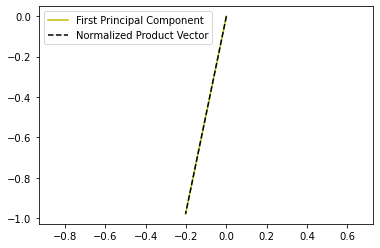

In [91]:
def plot_vector(vector, **kwargs):
    plt.plot([0, vector[0]], [0, vector[1]], **kwargs)

plot_vector(first_pc, c='y', label='First Principal Component')
product_vector = cov_matrix @ first_pc
product_vector /= norm(product_vector)
plot_vector(product_vector, c='k', linestyle='--',
            label='Normalized Product Vector')

plt.legend()
plt.axis('equal')
plt.show()

The maxtrix-vector product of `cov_matrix` and `first_pc` points in the same direction as `first_pc`. Thus, by definition, `first_pc` is an **eigenvector** of `cov_matrix`. An eigenvector of a matrix satisfies the following special property; the product of the matrix and the eigenvector points in the same direction as the eigenvector. The direction will not shift, no matter how many times we take the product.

**Listing 14. 42. Computing the angle between eigenvector products**

In [92]:
product_vector2 = cov_matrix @ product_vector
product_vector2 /= norm(product_vector2)
cosine_similarity = product_vector @ product_vector2
angle = np.degrees(np.arccos(cosine_similarity))
print(f"The angle between vectors equals {angle:.2f} degrees")

The angle between vectors equals 0.00 degrees


The product of a matrix and its eigenvector maintains the eigenvector's direction. However, in most cases, it will alter the eigenvector's magnitude.

**Listing 14. 43. Measuring the shift in magnitude**

In [93]:
new_magnitude = norm(cov_matrix @ first_pc)
print("Multiplication has stretched the first principal component by "
      f"approximately {new_magnitude:.1f} units.")

Multiplication has stretched the first principal component by approximately 541.8 units.


Multiplication has stretched-out `first_pc` by 541.8 units. That numeric value is formally called the **eigenvalue**. 
Our eigenvalue of 541.8 may seem familiar. This is because it equals the variance along the first principal direction.

**Listing 14. 44. Comparing an eigenvalue to the variance**

In [87]:
variance = (centered_data.T @ first_pc).var()
direction1_var = projections[0].var()
print("The variance along the first principal direction is approximately" 
       f" {variance:.1f}")

The variance along the first principal direction is approximately 541.8


Mathematicians have proven the following:

* The principal components of a dataset are equal to the normalized eigenvectors of the dataset's covariance matrix.
* The variance along a principal direction is equal to the eigenvalue of the associated principal component.

Consequently, to uncover the first principal component, we need to:
1. Compute the covariance matrix.
2. Find the eigenvector of the matrix with the largest eigenvalue. 

We can extract the eigenvector with the largest eigenvalue using an algorithm called **power iteration**.

### 14.4.1. Extracting Eigenvectors Using Power Iteration

Our goal is to obtain the eigenvectors of `cov_matrix` . We'll start by generating a random unit-vector, `random_vector`.

**Listing 14. 45. Generating a random unit-vector**

In [88]:
np.random.seed(0)
random_vector = np.random.random(size=2)
random_vector /= norm(random_vector)

Next, we'll compute `cov_matrix @ random_vector`. This matrix-vector product will both rotate and stretch our random vector. We'll normalize the new vector so that its magnitude is comparable to `random_vector`.

**Listing 14. 46. Taking the product of `cov_matrix` and `random_vector`**

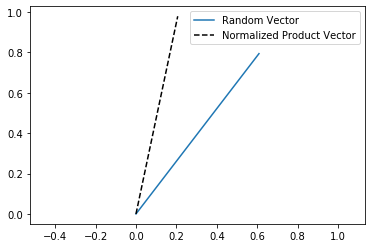

In [89]:
product_vector = cov_matrix @ random_vector
product_vector /= norm(product_vector) 

plt.plot([0, random_vector[0]], [0, random_vector[1]], 
          label='Random Vector')
plt.plot([0, product_vector[0]], [0, product_vector[1]], linestyle='--',
         c='k', label='Normalized Product Vector')

plt.legend()
plt.axis('equal')
plt.show()

Our 2 vectors have nothing in common. Lets see what happens when we repeat the procedure by running `cov_matrix @ product_vector`.

**Listing 14. 47. Taking the product of cov_matrix and product_vector**

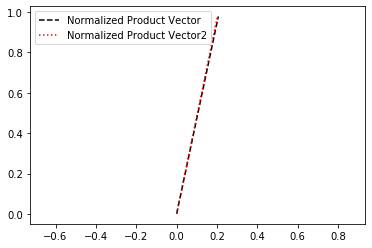

In [90]:
product_vector2 = cov_matrix @ product_vector
product_vector2 /= norm(product_vector2) 

plt.plot([0, product_vector[0]], [0, product_vector[1]], linestyle='--',
         c='k', label='Normalized Product Vector')
plt.plot([0, product_vector2[0]], [0, product_vector2[1]], linestyle=':',
         c='r', label='Normalized Product Vector2')
plt.legend()
plt.axis('equal')
plt.show()

Our product vectors point in an identical direction! Therefore, `product_vector` is an eigenvector of `cov_matrix`. Basically, we’ve carried out a power iteration. Lets define a `power_iteration` function. 

**Listing 14. 48. Implementing the power iteration algorithm**

In [91]:
np.random.seed(0)
def power_iteration(matrix):
    random_vector = np.random.random(size=matrix.shape[0])
    random_vector = random_vector / norm(random_vector)
    old_rotated_vector = random_vector
    for _ in range(10):
        rotated_vector = matrix @ old_rotated_vector
        rotated_vector = rotated_vector / norm(rotated_vector)
        old_rotated_vector = rotated_vector
    
    eigenvector = rotated_vector
    eigenvalue = norm(matrix @ eigenvector)
    return eigenvector, eigenvalue

eigenvector, eigenvalue = power_iteration(cov_matrix)
print(f"The extracted eigenvector is {eigenvector}")
print(f"Its eigenvalue is approximately {eigenvalue: .1f}")

The extracted eigenvector is [0.20223994 0.979336  ]
Its eigenvalue is approximately  541.8


Our function returned the principal component with the largest variance coverage. The second principal component is also an eigenvector. How do we find it? 

In order to extract the second eigenvector, we must eliminate all traces of the first eigenvector from `cov_matrix`. This process is known as **matrix deflation**. Once a matrix is deflated, its second-largest eigenvalue will become its largest eigenvalue. In order to deflate `cov_matrix`, we must take the **outer product** of `eigenvector` with itself. That outer product is computed by taking the pairwise product of `eigenvector[i] * [j]` for every possible value of `i` and `j`.

**Listing 14. 49. Computing the outer product of an eigenvector with itself**

In [92]:
outer_product = np.outer(eigenvector, eigenvector)
for i in range(eigenvector.size):
    for j in range(eigenvector.size):
        assert outer_product[i][j] == eigenvector[i] * eigenvector[j]

Given the outer product, we can deflate `cov_matrix` by running `cov_matrix - eigenvalue * outer_product`. That basic operation will produce a matrix whose primary eigenvector is equal to the second principal component.

**Listing 14. 50. Deflating the covariance matrix**

In [93]:
deflated_matrix = cov_matrix - eigenvalue * outer_product

Running `product_iteration(deflated_matrix)` will return an eigenvector, That eigenvector will equal the second principal component. Projecting on both principal components will recreate our cigar-shaped plot.

**Listing 14. 51. Extracting the second principal component from the deflated matrix**

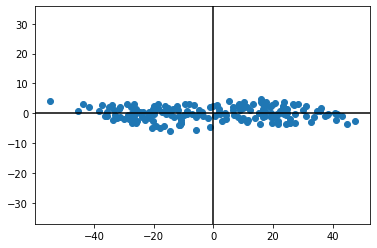

In [94]:
np.random.seed(0)
next_eigenvector, _ = power_iteration(deflated_matrix)
components = np.array([eigenvector, next_eigenvector])
projections = components @ centered_data
plt.scatter(projections[0], projections[1])
plt.axhline(0, c='black')
plt.axvline(0, c='black')
plt.axis('equal')
plt.show()

We've basically developed an algorithm for extracting the top K principal components of a matrix whose axis-means are zero. Lets implement the algorithm, by defining `find_top_principal_components`.

**Listing 14. 52. Extracting the top K principal components**

In [95]:
def find_top_principal_components(centered_matrix, k=2):
    cov_matrix = centered_matrix @ centered_matrix.T
    cov_matrix /= centered_matrix[1].size
    return find_top_eigenvectors(cov_matrix, k=k)
 
def find_top_eigenvectors(matrix, k=2):
    matrix = matrix.copy()
    eigenvectors = []
    for _ in range(k):
        eigenvector, eigenvalue = power_iteration(matrix)
        eigenvectors.append(eigenvector)
        matrix -= eigenvalue * np.outer(eigenvector, eigenvector)
    
    return np.array(eigenvectors)


We’re now able to run PCA from scratch, without relying on Scikit-Learn. Lets execute this implementation by defining a `reduce_dimensions` function. Why not name the function `pca`? Well, the first 2 steps of the PCA require us to centralize our data. However, we'll soon learn that dimension reduction can be achieved without centralization. Thus, we'll pass an optional `centralize_data` parameter into our function. We'll preset the parameter to `True`, guaranteeing that the function executes PCA under default conditions.

**Listing 14. 53. Defining a `reduce_dimensions` function**

In [96]:
def reduce_dimensions(data, k=2, centralize_data=True):
    data = data.T.copy()
    if centralize_data:
        for i in range(data.shape[0]):
            data[i] -= data[i].mean() 
            
    principal_components = find_top_principal_components(data)
    return (principal_components @ data).T

Lets test `reduce_dimensions` by applying to our previously analyzed `flower_measurements` data.

**Listing 14. 54. Reducing flower data to 2D using a custom PCA implementation**

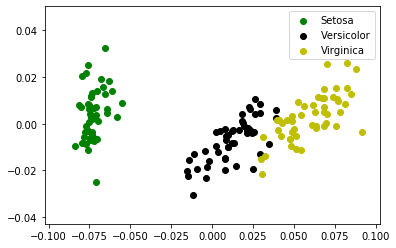

In [97]:
np.random.seed(0)
dim_reduced_data = reduce_dimensions(flower_measurements)
visualize_flower_data(dim_reduced_data)

We have re-engineered Sckit-Learn’s implementation, but with one big difference. In our function, centralization is optional. As we’ve discussed, we can’t reliably perform centralization on normalized data. One alternative is to bypass centralization, by passing `centralize_data=False` into our `reduce_dimensions` function.

**Listing 14. 55. Running `reduce_dimensions` without centralization**

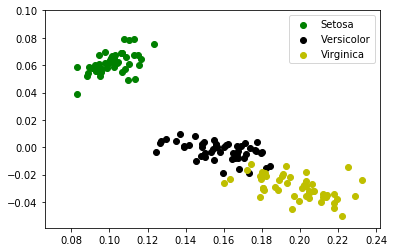

In [98]:
np.random.seed(3)
dim_reduced_data = reduce_dimensions(flower_measurements, 
                                     centralize_data=False)
visualize_flower_data(dim_reduced_data)

Within the output, the 3 species of flowers continue to separate into 3 clusters. Does this output continue to represent 97% of the total data variance? We can check by measuring the variance of `dim_reduced_data` and dividing it by the total variance of `flower_measurements`.

**Listing 14. 56. Checking the variance of data reduced without centralization**

In [99]:
variances = [sum(data[:,i].var() for i in range(data.shape[1]))
             for data in [dim_reduced_data, flower_measurements]]
dim_reduced_var, total_var = variances
percent_coverege = 100 * dim_reduced_var / total_var
print(f"Our plot covers {percent_coverege:.2f}% of the total variance")

Our plot covers 97.29% of the total variance


The variance coverage remains at approximately 97%. We thusly can reduce dimensionality without relying on centralization. Our modefied technique is called **Singular Value Decomposition**, or **SVD** for short. An efficient SVD implementation is available in Scikit-Learn.

## 14.5. Efficient Dimension Reduction Using SVD and Scikit-Learn

Scikit-Learn contains a dimension reduction class called `TruncatedSVD`.  Lets import `TruncatedSVD` from `sklearn.decomposition`.

**Listing 14. 57. Importing `TruncatedSVD` from Scikit-Learn**

In [100]:
from sklearn.decomposition import TruncatedSVD

Lets apply `TrucatedSVD` to `flower_measurements`.

**Listing 14. 58. Running SVD using Scikit-Learn**

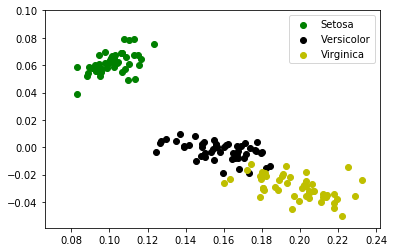

In [101]:
svd_object = TruncatedSVD(n_components=2)
svd_object = TruncatedSVD(n_components=2)
svd_transformed_data = svd_object.fit_transform(flower_measurements)
visualize_flower_data(svd_transformed_data)

Not surprisingly, Scikit-Learn's results are identical to our custom SVD implementation. We can further verify the overlap between our output and Scikit-Learn's by comparing variance coverage results.

**Listing 14. 59. Extracting variance from Scikit-Learn’s SVD output**

In [103]:
percent_variance_coverages = 100 * svd_object.explained_variance_ratio_
x_axis_coverage, y_axis_coverage = percent_variance_coverages
total_2d_coverage = x_axis_coverage + y_axis_coverage
print(f"Our Scikit-Learn SVD output covers {total_2d_coverage:.2f}% of "
       "the total variance")

Our Scikit-Learn SVD output covers 97.29% of the total variance
